# How to use R packages in Python

As a data scientist working with biological data, the programming language I use on a daily basis is Python. However, I sometimes find myself needing to use an R package, such as those provided by  [Bioconductor](https://www.bioconductor.org/). For me this is most often the excellent [MSstats](https://msstats.org/) R package for anlayzing mass spectrometry proteomics data that was from Meena Choi ([@MeenaChoi](https://twitter.com/MeenaChoi)) and Olga Vitek's lab ([@olgavitek](https://twitter.com/olgavitek)). Although it has always been possible to write R scripts alongside my Python scripts and Jupyter notebooks, I find it cumbersome to switch back and forth between them, particularly when it involves generating unnecessary intermediate files.

In this post I'll show you how I use the MSstats R package from within a Python script or Jupyter notebook, providing an example for how you can use the occasional R package in your own analyses. This post will assume that you're comfortable programming in Python and that you're familiar with the Pandas, NumPy, and Matplotlib Python packages.[^1] Additionally, I'll assume that you have some familiarity with R programming, since you're reading this post. I'll be using mass spectrometry proteomics data as an example, but understanding it is not critical for learning from this post.

[^1]:If these are not familiar and you want to learn, I recommend the ["Plotting and Programming in Python"](http://swcarpentry.github.io/python-novice-gapminder/) Software Carpentry course. 

This entire post is available as a Jupyter notebook on GitHub: https://github.com/wfondrie/msstats-demo

## Setup
If you want to follow along with this post, you'll need to install a few things. I use conda as my package manager for Python and R whenever possible.[^2] First, we'll create a new conda environment, `msstats-demo`, and install the necessary packages from the [bioconda](https://bioconda.github.io/) and [conda-forge](https://conda-forge.org/) channels. I've created a conda environment YAML file that looks like this:

[^2]: If you need to install conda, I'd recommend the [miniconda distribution](https://docs.conda.io/en/latest/miniconda.html).

```yaml
# https://github.com/wfondrie/msstats-demo/environment.yaml
name: msstats-demo
channels:
  - bioconda
  - conda-forge
  - defaults
dependencies:
  - ppx>=1.2.5                   # For downloading data
  - bioconductor-msstats==4.2.0  # The MSstats R package
  - notebook                     # Jupyter notebook
  - ipywidgets                   # For progress bars
  - pandas                       # DataFrames for tabular data
  - numpy                        # To do math
  - matplotlib                   # The de facto standard Python plotting library
  - seaborn                      # Make matplotlib plots pretty
  - rpy2                         # For using R packages in Python!
```

Let's start by creating the conda environment from this file:
```bash
conda env create -f https://raw.githubusercontent.com/wfondrie/msstats-demo/main/environment.yaml
```

Then activate our new conda environment:  
```bash
conda activate msstats-demo
```

Now let's fire up Python. If you want to use a [Jupyter notebook](https://jupyter.org/), you can launch it with:
```bash
jupyter notebook 
```

Then click `New` &#8594; `Python 3 (ipykernel)` to open a new notebook. 

## Getting started

For this post, we're going to reproduce an analysis of the the dataset from [Selevsek et al](https://doi.org/10.1074/mcp.M113.035550) as performed in the [MassIVE.quant paper](https://doi.org/10.1038/s41592-020-0955-0). We'll use Python to download and read the data, process that data with the MSstats R package, then recreate the volcano plot in Figure 2j with Python. Let's start by loading the libraries we'll need into our Python session:

In [1]:
import ppx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# These will let us use R packages:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

# Convert pandas.DataFrames to R dataframes automatically.
pandas2ri.activate()

The [rpy2](https://rpy2.github.io/) Python package will perform the magic that allows us to use R packages in our Python session. The `importr` function give us the power to import R packages and `pandas2ri`---along with the subsequent `pandas2ri.activate()` line---will allow our Pandas DataFrames to be automically converted into R data frames when used as input to an R function.

We also need to set up a plotting style that looks nice on my website:

In [2]:
# Set plotting theme:
primary = "#404040"
accent = "#24B8A0"
pal = sns.color_palette([primary, accent])
style = {
    "axes.edgecolor": primary,
    "axes.labelcolor": primary,
    "text.color": primary,
    "xtick.color": primary,
    "ytick.color": primary,
}

sns.set_palette(pal)
sns.set_context("talk")
sns.set_style("ticks", style)

Now let's download the dataset from the [MassIVE mass spectrometry data repository](https://massive.ucsd.edu/ProteoSAFe/static/massive.jsp) under the accession RMSV000000251. We'll use the [ppx Python package](https://ppx.readthedocs.io) to do this: 

In [3]:
proj = ppx.find_project("RMSV000000251")

# The proteomics data:
quant_file = "2019-06-03_mnchoi_bb4aeafb/quant/Selevsek2015-MSstats-input-90nodup-i.csv"

# The annotation file:
annot_file = "2019-06-03_mnchoi_bb4aeafb/metadata/Selevsek2015_DIA_Skyline_all_annotation.csv"

# The local paths to them:
quant_path, annot_path = proj.download([quant_file, annot_file], silent=True)

We can then read the proteomics data into our Python session using Pandas:

In [4]:
quant_df = pd.read_csv(quant_path, dtype={"StandardType": str})
quant_df.head() # View the first five rows

,ProteinName,PeptideSequence,PeptideModifiedSequence,PrecursorCharge,PrecursorMz,FragmentIon,ProductCharge,ProductMz,IsotopeLabelType,Condition,BioReplicate,FileName,Area,StandardType,Truncated,DetectionQValue
0,Biognosys standards,LGGNEQVTR,LGGNEQVTR,2,487.256705,y7,1,803.400606,light,NaN,NaN,nselevse_L120412_001_SW.wiff,353982.43750,iRT,False,NaN
1,Biognosys standards,LGGNEQVTR,LGGNEQVTR,2,487.256705,y7,1,803.400606,light,NaN,NaN,nselevse_L120412_002_SW.wiff,408376.46875,iRT,False,NaN
2,Biognosys standards,LGGNEQVTR,LGGNEQVTR,2,487.256705,y7,1,803.400606,light,NaN,NaN,nselevse_L120412_003_SW.wiff,437152.65625,iRT,False,NaN
3,Biognosys standards,LGGNEQVTR,LGGNEQVTR,2,487.256705,y7,1,803.400606,light,NaN,NaN,nselevse_L120412_004_SW.wiff,344150.12500,iRT,False,NaN
4,Biognosys standards,LGGNEQVTR,LGGNEQVTR,2,487.256705,y7,1,803.400606,light,NaN,NaN,nselevse_L120412_005_SW.wiff,383755.62500,iRT,False,NaN


We also need to read the annotation data using Pandas:

In [5]:
annot_df = pd.read_csv(annot_path)
annot_df.head()

,Condition,BioReplicate,Run
0,T000,1,nselevse_L120412_001_SW.wiff
1,T000,2,nselevse_L120412_002_SW.wiff
2,T000,3,nselevse_L120412_003_SW.wiff
3,T015,1,nselevse_L120412_004_SW.wiff
4,T015,2,nselevse_L120412_005_SW.wiff


Finally, we need to create a contrast matrix that will define the comparisons we want to test with MSstats:

In [6]:
cols = annot_df["Condition"].unique()
cols.sort()

rows = ["T1-T0", "T2-T0", "T3-T0", "T4-T0", "T5-T0"]

contrasts = [
    [-1, 1, 0, 0, 0, 0],
    [-1, 0, 1, 0, 0, 0],
    [-1, 0, 0, 1, 0, 0],
    [-1, 0, 0, 0, 1, 0],
    [-1, 0, 0, 0, 0, 1],
]

contrast_df = pd.DataFrame(
    contrasts,
    columns=cols,
    index=rows,
)

contrast_df

,T000,T015,T030,T060,T090,T120
T1-T0,-1,1,0,0,0,0
T2-T0,-1,0,1,0,0,0
T3-T0,-1,0,0,1,0,0
T4-T0,-1,0,0,0,1,0
T5-T0,-1,0,0,0,0,1


## Run MSstats in Python using rpy2

Now for the fun part: let's run MSstats without leaving our Python session. Just like if we were using R directly, we first need to import the libraries that we'll be using. This looks a little different using rpy2, but ultimately we assign the imported R package to a variable that we can use like any other Python package. Here, we import MSstats:

In [7]:
MSstats = importr("MSstats")

Next, we'll perform our MSstats data processing. Note that each of these functions actually call the underlying MSstats R package. The rpy2 Python package does all of the work tranforming our Pandas DataFrames (`quant_df`, `annot_df`, and `contrast_df`) into R data frames that MSstats can use. When each function is complete, it returns an R object. Fortunately, we've setup rpy2 to automatically convert R data frames back into Pandas DataFrames, allowing us to use the results seamlessly. The final output returned by MSstats in this analysis (`results` below)  will be a Pandas DataFrame containing the p-values for each protein for contrasts that we specified in our contrast matrix (`contrast_df`).

If you're following along, this next step may take a few minutes. Go ahead and enjoy a cup of coffee or your favorite beverage while it's running.

In [8]:
raw = MSstats.SkylinetoMSstatsFormat(
    quant_df,
    annotation=annot_df,
    removeProtein_with1Feature=True,
    use_log_file=False,
)

processed = MSstats.dataProcess(
    raw, 
    use_log_file=False,
)

# Note that the 'contrast_matrix' argument below
# is actually 'contrast.matrix' in the MSstats
# R package. rpy2 swaps '.' for '_' so that it
# becomes a valid Python variable name.
results, *_ = MSstats.groupComparison(
    contrast_matrix=contrast_df, 
    data=processed,
    use_log_file=False,
)

INFO  [2022-01-07 15:30:17] ** Raw data from Skyline imported successfully.
INFO  [2022-01-07 15:31:07] ** Raw data from Skyline cleaned successfully.
INFO  [2022-01-07 15:31:07] ** Using provided annotation.
INFO  [2022-01-07 15:31:07] ** Run labels were standardized to remove symbols such as '.' or '%'.
INFO  [2022-01-07 15:31:07] ** The following options are used:
  - Features will be defined by the columns: IsotopeLabelType, PeptideSequence, PrecursorCharge, FragmentIon, ProductCharge
  - Shared peptides will be removed.
  - Proteins with a single feature will be removed.
  - Features with less than 3 measurements across runs will be removed.
INFO  [2022-01-07 15:31:07] ** Rows with values of StandardType equal to iRT are removed 
INFO  [2022-01-07 15:31:08] ** Intensities with values of Truncated equal to TRUE are replaced with NA
INFO  [2022-01-07 15:31:11] ** Intensities with values smaller than 0.01 in DetectionQValue are replaced with 0
INFO  [2022-01-07 15:31:11] ** Sequences

Now that the process is complete, we can verify that `results` is a Pandas DataFrame containing our MSstats results:

In [9]:
results.head()

,Protein,Label,log2FC,SE,Tvalue,DF,pvalue,adj.pvalue,issue,MissingPercentage,ImputationPercentage
1,Q0250,T1-T0,0.001292,0.111103,0.011625,10,0.990953,0.995633,None,0.033333,0.033333
2,Q0250,T2-T0,-0.106017,0.111103,-0.954230,10,0.362464,0.533674,None,0.066667,0.066667
3,Q0250,T3-T0,-0.123694,0.111103,-1.113334,10,0.291610,0.442217,None,0.100000,0.100000
4,Q0250,T4-T0,0.267058,0.111103,2.403706,10,0.037080,0.111271,None,0.033333,0.033333
5,Q0250,T5-T0,0.242798,0.111103,2.185348,10,0.053757,0.120164,None,0.033333,0.033333


We've successfully run MSstats without leaving our Python session!

## Reproduce a figure panel from the paper

The only task left is reproduce a panel from a figure in the MassIVE.quant paper. We'll recreate the volcano plot from Figure 2j and see how close our results are to the original.[^3] However, we'll make this plot using [seaborn](https://seaborn.pydata.org/) and [matplotlib](https://matplotlib.org/) in our Python session!

[^3]: I haven't included the original figure for copyright reasons.

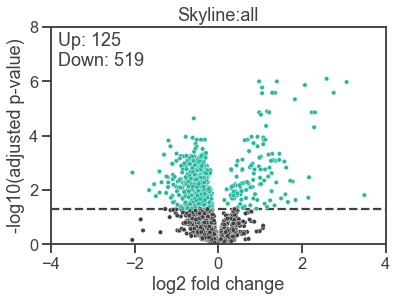

In [10]:
# Filter the results for the points we want to plot
results = results.loc[results["adj.pvalue"] > 0, :]
results = results.loc[results["Label"] == "T5-T0", :]
results["accepted"] = results["adj.pvalue"] <= 0.05
results["neg_log_pvalue"] = -np.log10(results["adj.pvalue"])

# Get the number of up and down-regulated proteins
n_up = ((results["log2FC"] > 0) & results["accepted"]).sum()
n_down = ((results["log2FC"] < 0) & results["accepted"]).sum()

# Create the figure
plt.figure()

# Create the Scatter plot
sns.scatterplot(
    data=results, 
    x="log2FC", 
    y="neg_log_pvalue",
    hue="accepted",
    legend=False,
    s=20
)

# Add annotations
plt.text(
    x=0.02, 
    y=0.98, 
    s=f"Up: {n_up}\nDown: {n_down}", 
    transform=plt.gca().transAxes,
    va="top",
)

# Add the horizontal line
plt.axhline(-np.log10(0.05), linestyle="dashed", zorder=0)

# Add labeling
plt.xlabel("log2 fold change")
plt.ylabel("-log10(adjusted p-value)")
plt.title("Skyline:all")

# Set the axes limits
plt.ylim(0, 8)
plt.xlim(-4, 4)

# Show the plot
plt.show()

This looks pretty close to the original to me, particularly considering that we didn't make any attempt to match our software versions with the original analysis. The number of up and down-regulated proteins is nearly identical, with our analysis finding one fewer down-regulated protein than in the original.

## Conclusion

The rpy2 Python package provides a pretty convenient way to use the occassional R package in Python, and I've shown you how to use it to run MSstats. Finally, I'll leave you with this: if you want to use the occasional Python package in R, try the [reticulate](https://rstudio.github.io/reticulate/) R package.